PyDrive activation Used for bypassing Google Drive download rate limit

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = False #@param {type:"boolean"}

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1 - Install Packages required by PTI

In [3]:
## Other packages are already builtin in the Colab interpreter
!pip install wandb
!pip install lpips

## Used for faster inference of StyleGAN by enabling C++ code compilation

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=45a1103eaca4ebb6994e0a4f27f0355c944be67c3e1e0e79c91e98e81513c949
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.7 MB/s eta 0:00:00
--2023-07-03 07:54:45--  https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response...

## Step 2 - Download Pretrained models

In [4]:
import os
os.chdir('/content')
CODE_DIR = 'PTI'

In [5]:
!git clone https://github.com/danielroich/PTI.git $CODE_DIR

Cloning into 'PTI'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 336 (delta 61), reused 52 (delta 49), pack-reused 241
Receiving objects: 100% (336/336), 13.70 MiB | 11.07 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [6]:
os.chdir(f'./{CODE_DIR}')

In [7]:
import os
import sys
import pickle
import numpy as np
from PIL import Image
import torch
from configs import paths_config, hyperparameters, global_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from IPython.display import display
import matplotlib.pyplot as plt
from scripts.latent_editor_wrapper import LatentEditorWrapper

In [8]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
os.makedirs(save_path, exist_ok=True)

In [9]:
paths_config.input_data_path

''

In [10]:
## Download pretrained StyleGAN on FFHQ 1024x1024
downloader.download_file("125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M", os.path.join(save_path, 'ffhq.pkl'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M
To: /content/PTI/pretrained_models/ffhq.pkl
100% 382M/382M [00:02<00:00, 177MB/s]


In [11]:
## Download Dlib tool for alingment, used for preprocessing images before PTI
downloader.download_file("1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR", os.path.join(save_path, 'align.dat'))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR
To: /content/PTI/pretrained_models/align.dat
100% 99.7M/99.7M [00:00<00:00, 225MB/s]


## Step 3 - Configuration Setup

In [12]:
image_dir_name = 'image'

## If set to true download desired image from given url. If set to False, assumes you have uploaded personal image to
## 'image_original' dir
use_image_online = True
image_name = 'image'
use_multi_id_training = False
global_config.device = 'cuda'
paths_config.e4e = '/content/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.input_data_id = image_dir_name
paths_config.input_data_path = f'/content/PTI/{image_dir_name}_processed'
paths_config.stylegan2_ada_ffhq = '/content/PTI/pretrained_models/ffhq.pkl'
paths_config.checkpoints_dir = '/content/PTI/'
paths_config.style_clip_pretrained_mappers = '/content/PTI/pretrained_models'
hyperparameters.use_locality_regularization = False

## Step 4 - Preproccess Data

In [13]:
os.makedirs(f'./{image_dir_name}_original', exist_ok=True)
os.makedirs(f'./{image_dir_name}_processed', exist_ok=True)
os.chdir(f'./{image_dir_name}_original')

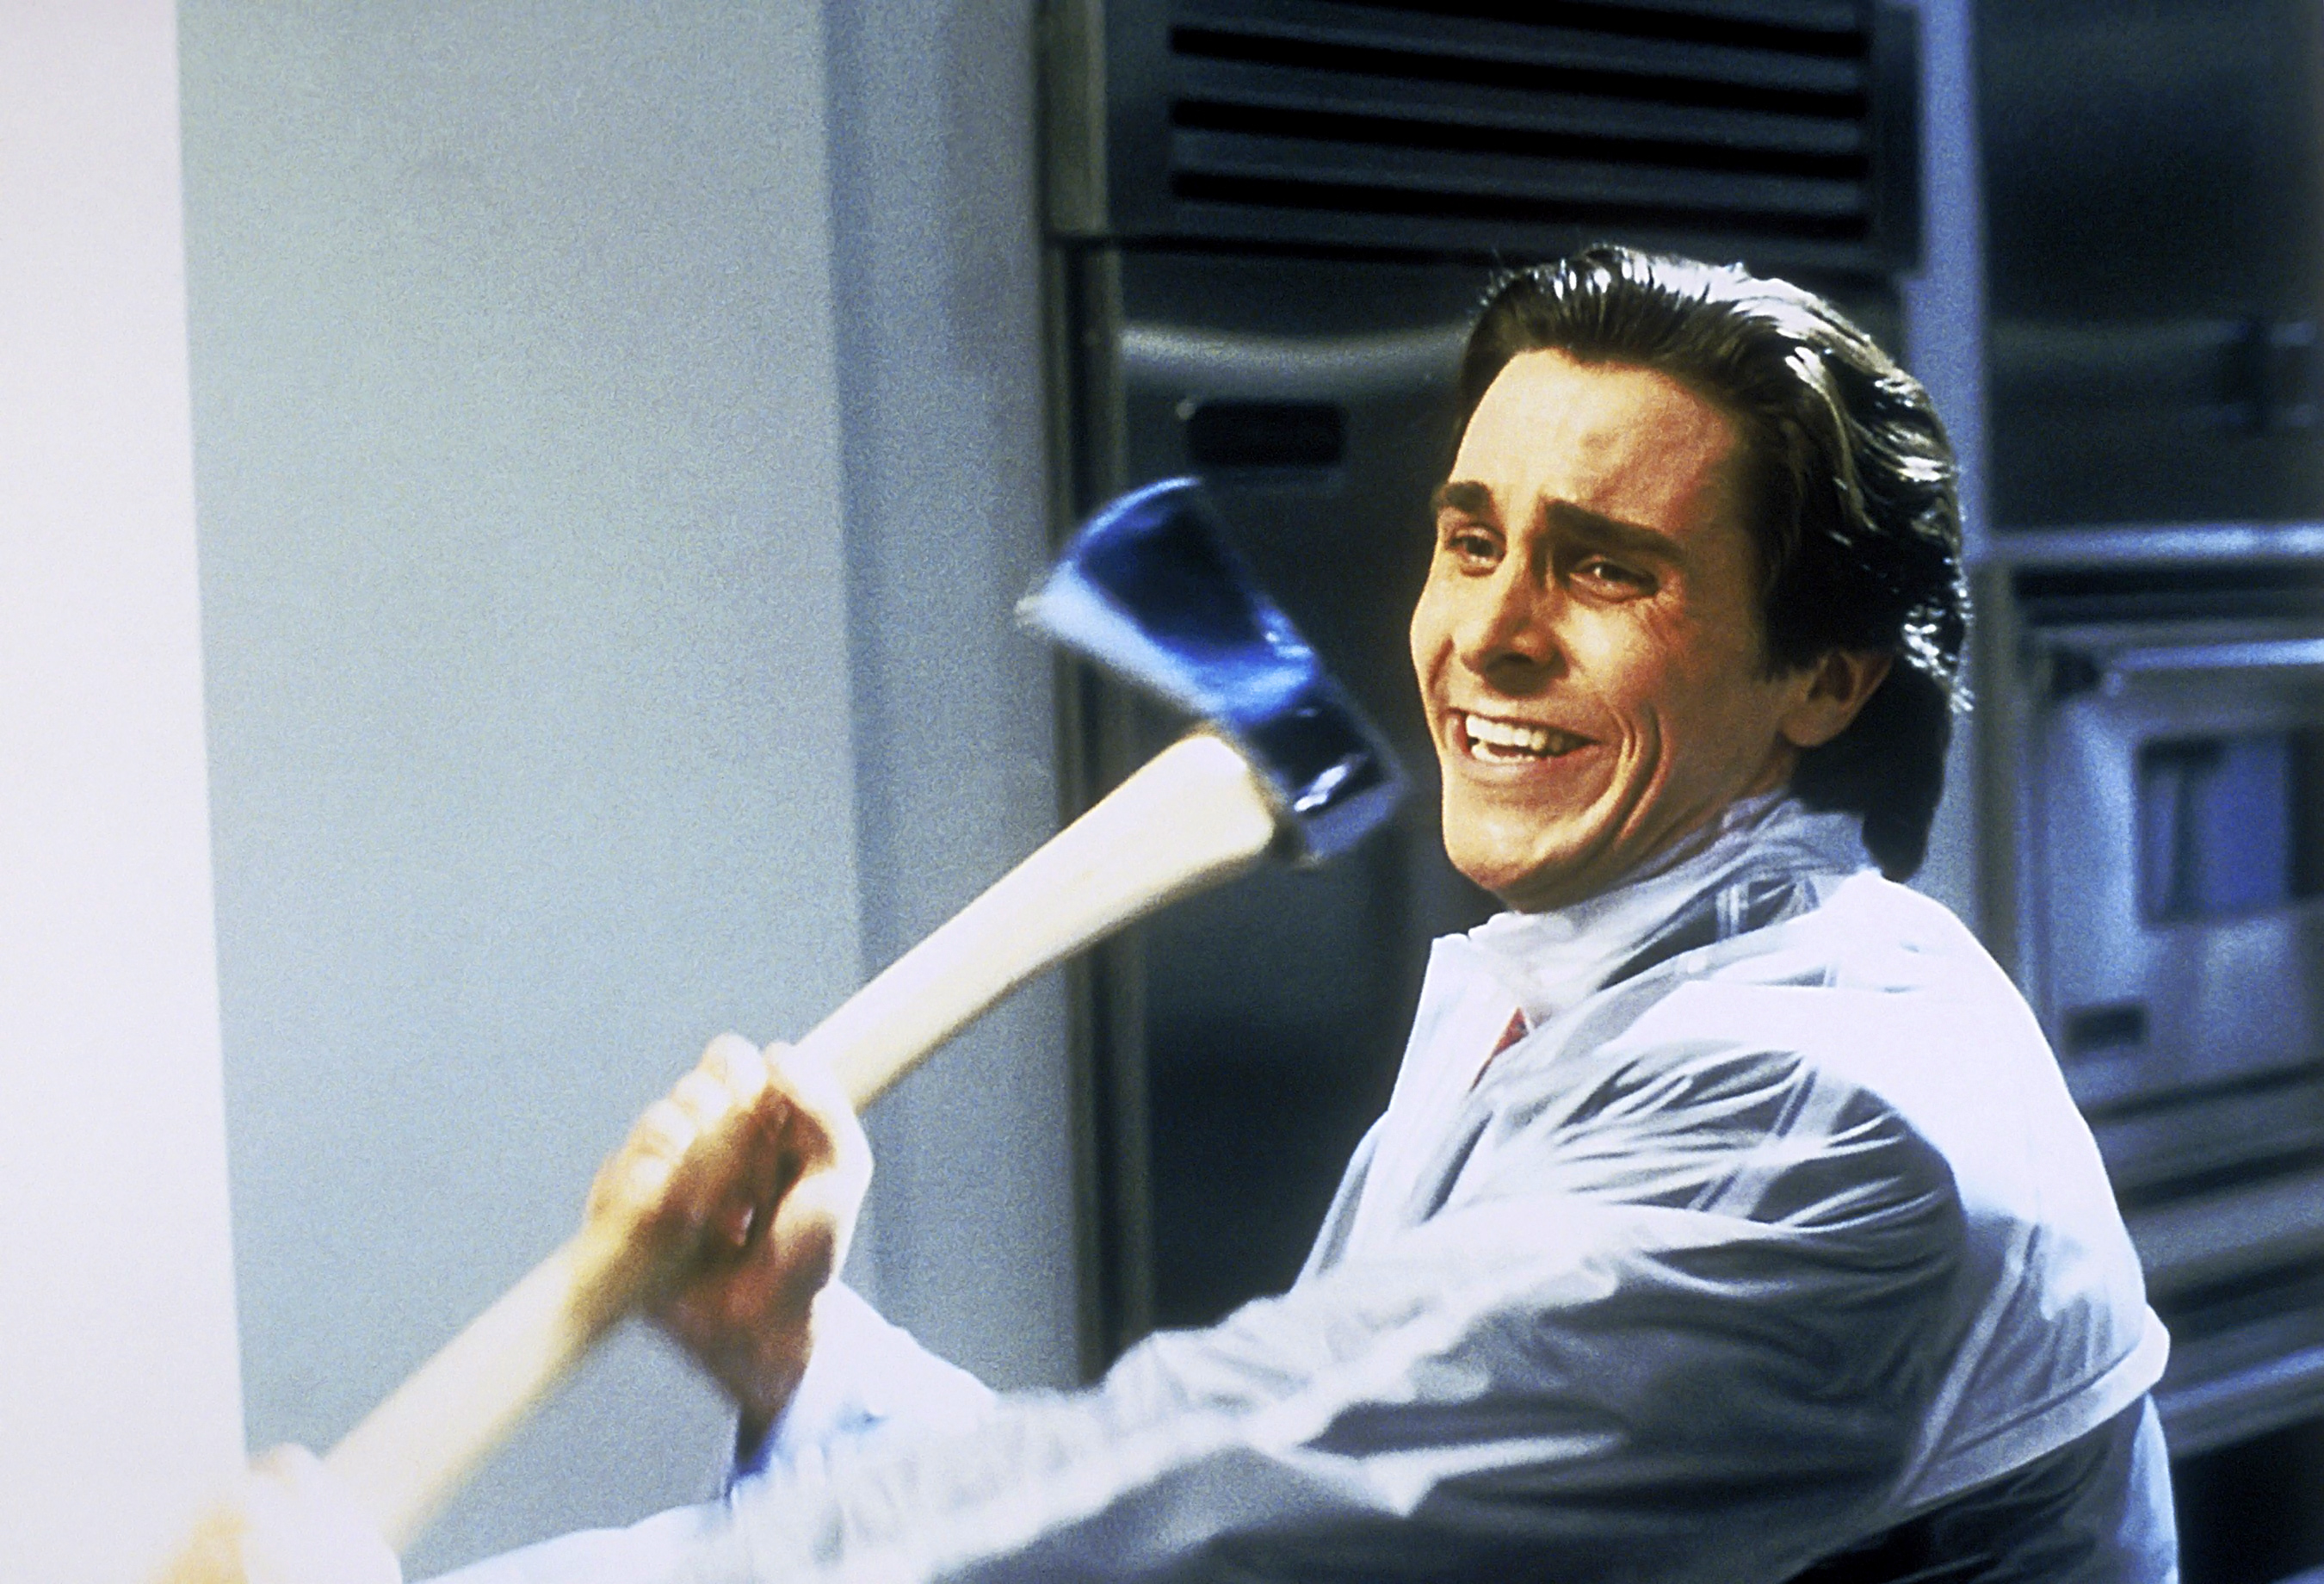

In [14]:
original_image = Image.open(f'{image_name}.jpeg')
original_image

In [15]:
os.chdir('/content/PTI')

In [16]:
image_dir_name

'image'

In [17]:
pre_process_images(f'/content/PTI/{image_dir_name}_original')

100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


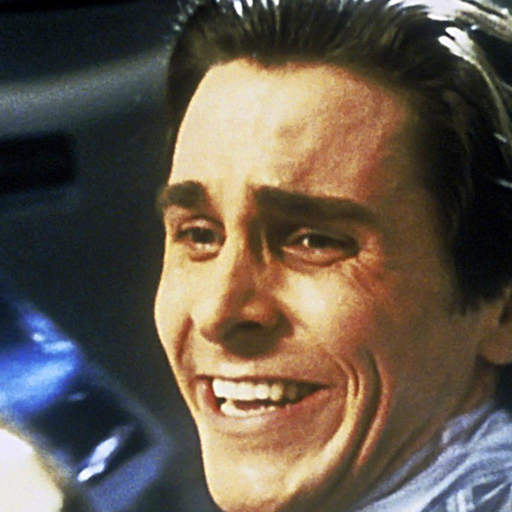

In [18]:
aligned_image = Image.open(f'/content/PTI/{image_dir_name}_processed/{image_name}.jpeg')
aligned_image.resize((512,512))

## Step 5 - Invert images using PTI

In order to run PTI and use StyleGAN2-ada, the cwd should the parent of 'torch_utils' and 'dnnlib'.

In case use_multi_id_training is set to True and many images are inverted simultaneously
activating the regularization to keep the *W* Space intact is recommended.

If indeed the regularization is activated then please increase the number of pti steps from 350 to 450 at least
using hyperparameters.max_pti_steps

In [19]:
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 54.2MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.



  0%|          | 0/450 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)

100%|██████████| 450/450 [02:17<00:00,  3.28it/s]

100%|██████████| 1/1 [04:11<00:00, 251.85s/it]


## Save Latent space and Model Weights

In [20]:
def load_generators(model_id, image_name):
  with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    old_G = pickle.load(f)['G_ema'].cuda()

  with open(f'{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt', 'rb') as f_new:
    new_G = torch.load(f_new).cuda()

  return old_G, new_G

In [21]:
generator_type = paths_config.multi_id_model_type if use_multi_id_training else image_name
old_G, new_G = load_generators(model_id, generator_type)

In [22]:
# code from issue link: https://github.com/danielroich/PTI/issues/26#issue-980150606

def export_updated_pickle(new_G,model_id):
  print("Exporting large updated pickle based off new generator and ffhq.pkl")
  with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    d = pickle.load(f)
    old_G = d['G_ema'].cuda() ## tensor
    old_D = d['D'].eval().requires_grad_(False).cpu()

  tmp = {}
  tmp['G'] = old_G.eval().requires_grad_(False).cpu()# copy.deepcopy(new_G).eval().requires_grad_(False).cpu()
  tmp['G_ema'] = new_G.eval().requires_grad_(False).cpu() # copy.deepcopy(new_G).eval().requires_grad_(False).cpu()
  tmp['D'] = old_D
  tmp['training_set_kwargs'] = None
  tmp['augment_pipe'] = None


  with open(f'{paths_config.checkpoints_dir}/stylegan2_custom_512_pytorch.pkl', 'wb') as f:
      pickle.dump(tmp, f)


export_updated_pickle(new_G,model_id)

Exporting large updated pickle based off new generator and ffhq.pkl
